In [41]:
# Clear all variables in the workspace
%reset -f

## Imports

In [42]:
import include.custom_helper_files.custom_system_properties as csp

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp

In [44]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

In [45]:
import oommfc as oc

## Main parameters

In [46]:
system = mm.System(name='dmi_new')

system_prop = csp.SystemProperties(length=2000e-9, width=200e-9, thickness=1e-9)
system_prop.cell = (2e-9, 2e-9, 1e-9)
system_prop.units = ('m', 'm', 'm')
#system_prop.update_lengths()
system_prop.update_numcells()

In [47]:
system_prop

SystemProperties(length=2e-06, width=8e-09, thickness=1e-09, cell=(2e-09, 2e-09, 1e-09), p1=(0, 0, 0), units=('m', 'm', 'm'), p2=(2e-06, 8e-09, 1e-09), numcells=(1000, 4, 1))

In [48]:
# Saturisation magnetisation
sat_mag = 8.6e5  # kA/m

# exchange stiffness
exchange_stiffness = 1.3e-11  # J/m

# External static Zeeman field strength
bias_field = tuple(x/mm.consts.mu0 for x in [0, 0.4, 0])  # A/m

# External dynamic Zeeman field strength
h0 = tuple(x/mm.consts.mu0 for x in [0.04, 0, 0])  # A/m

# Driving frequency
f = 60e9  # Hz

# Stepsize at which equations are evaluated
h = 1e-12  # s

#
num_steps = 4000

# Gilbert damping
alpha = 0.01

# DMI constant
D_ij = 3e-3  # J/m^2

gamma0 = 2.13e5 / mm.consts.mu0  # 29.2e9 * (2 * np.pi * mm.consts.mu0) # [Hz / (rad T)] to correct units

## Regions

In [49]:
system_region = csp.MyRegions(system.name + "_regions");

system_region.main(p1=system_prop.p1, p2=system_prop.p2, 
                   dims=('x', 'y', 'z'), units=system_prop.units);

Created subregion: main


In [50]:
%%capture
system_subregions = csp.MyRegions(system.name + "_subregions")

system_subregions.fixedLhs(p1=system_region.main.p1, 
                           p2=(system_prop.cell[0], system_prop.width, system_prop.thickness), 
                           dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingLhs(p1=csp.add_tuples(system_subregions.fixedLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.fixedLhs.p2, system_prop.cell, 
                                       mult=150, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeLhs(p1=csp.add_tuples(system_subregions.dampingLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.dampingLhs.p2, system_prop.cell, 
                                       mult=275, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.freeLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeLhs.p2, system_prop.cell,
                                           mult=75, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeRhs(p1=csp.add_tuples(system_subregions.driven.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.driven.p2, system_prop.cell, 
                                       mult=275, dims='x'),
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingRhs(p1=csp.add_tuples(system_subregions.freeRhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeRhs .p2, system_prop.cell, 
                                       mult=150, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.fixedRhs(p1=(1998e-9, 0, 0),
                           p2=system_region.main.p2, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

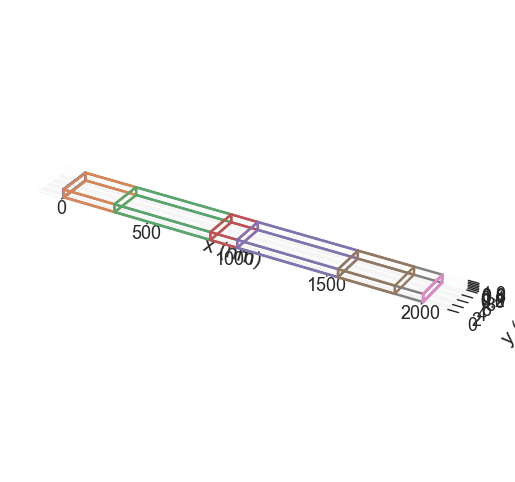

In [51]:
system_region._mesh = df.Mesh(region=system_region.main.region, 
                              cell=system_prop.cell,
                              subregions=system_subregions.regions)

system_region._mesh.mpl.subregions(figsize=(8, 6), multiplier=1e-9,box_aspect=(50, 5, 1), show_region=True)

### Energy equations

In [52]:
def h0_func(pos):
    if pos in system_subregions.driven.region:
        return h0
    else:
        return (0, 0, 0)
    #x, y, z = pos
    
    #if system_subregions.driven.p1[0] <= x < system_subregions.driven.p2[0]:
    #    return h0
    #else:
    #    return (0,0,0)

In [53]:
# system_subregions.driven.mesh = df.Mesh(region=system_region.main.region, cell=system_prop.cell)

In [54]:
h0_field = df.Field(mesh=system_region._mesh, nvdim=3, value=h0_func)
#region_values = {"region1": (1, 1, 1), "region2": (2, 2, 2)}
#h0_field.update_field_values(region_values)

In [55]:
system.energy = mm.Zeeman(H=bias_field, name='static') + mm.Exchange(A=exchange_stiffness) + mm.DMI(D=D_ij, crystalclass='Cnv_z')

In [56]:
system.energy

Zeeman(H=(0.0, 0.0, 318309.8861837907)) + Exchange(A=2.1e-11) + DMI(D=0.003, crystalclass='Cnv_z')

### dynamics

In [57]:
def alpha_abc_func(pos):
    # current positions
    x, y, z = pos  # spatial coordinates
    xn, yn, zn = (coord * 1e9 for coord in pos)  # cell coordinates
    
    # min and max cell coordinates of system
    xmin, ymin, zmin = (p1_val * 1e9 for p1_val in system_prop.p1)
    xmax, ymax, zmax = (p2_val * 1e9 for p2_val in system_prop.p2)
    
    # A.B.C. widths
    widths = {'x': 20, 'y':100, 'z': 1}

    # left (a) and right (b) bounds of the A.B.C. region
    xa, ya, za = xmin + widths['x'], ymin + widths['y'], zmin + widths['z']
    xb, yb, zb = xmax - widths['x'], ymax - widths['y'], zmax - widths['z']
    
    # Scales damping between [alpha, 1.0]
    if xn <= xa:
        return np.exp( ((xmin - xn) * np.log(alpha)) / (xmin - xa) )
    elif xn >= xb:
        return np.exp( ((xmax - xn) * np.log(alpha)) / (xmax - xb) )
    else:
        return alpha

In [58]:
alpha_field = df.Field(mesh=system_region._mesh, nvdim=1, value=alpha_abc_func)

In [59]:
system.dynamics = mm.Precession(gamma0=gamma0*mm.consts.mu0 ) + mm.Damping(alpha=alpha_field)

In [60]:
system.dynamics

Precession(gamma0=213000.0) + Damping(alpha=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[2e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[1000, 4, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[2e-09, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[2e-09, 0.0, 0.0], pmax=[3.0200000000000003e-07, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[3.0200000000000003e-07, 0.0, 0.0], pmax=[8.520000000000001e-07, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[8.520000000000001e-07, 0.0, 0.0], pmax=[1.002e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[1.002e-06, 0.0, 0.0], pmax=[1.5520000000000001e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingRhs`(pmin=[1.5520000000000001e-06, 0.0, 0.0], pmax=[1.8520000000000002e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), 

In [61]:
def m_init_func(pos):
    if pos in system_subregions.fixedLhs.region or pos in system_subregions.fixedRhs.region:
        return (0.0, 0.0, 1.0)
    else:
        return (0.1, 0.0, 0.9)

In [62]:
#system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=mag_vals, norm=Ms)
system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=m_init_func, norm=sat_mag)

### Relaxation

In [63]:
minD = oc.MinDriver()
minD.drive(system)  # fixed_subregions=['fixedLhs', 'fixedRhs']

Running OOMMF (TclOOMMFRunner)[2024/06/10 16:00]... (0.8 s)


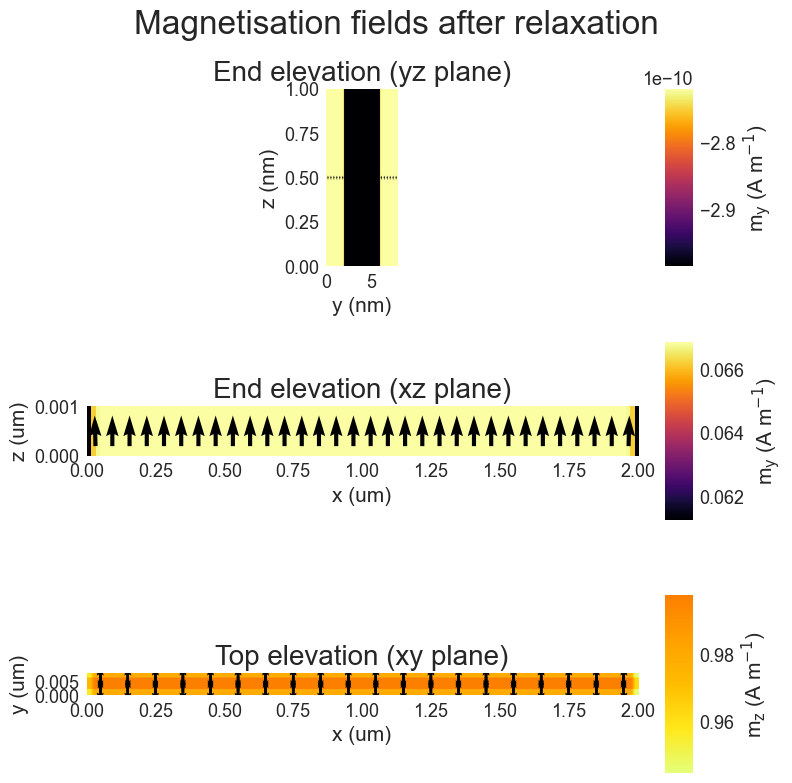

In [64]:
fig1, fig1_axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))
fig1.suptitle('Magnetisation fields after relaxation', fontsize=24)

system.m.orientation.sel('x').resample((48, 1)).x.mpl.scalar(ax=fig1_axs[0], cmap='inferno', colorbar_label='m$_\\text{y}$ (A m$^{-1}$)')
system.m.orientation.sel('x').resample((24, 1)).mpl.vector(ax=fig1_axs[0], 
                                               vdims=['x', 'z'],
                                               color_field=system.m.z.sel("y"),
                                               use_color=False,
                                               colorbar=False)
fig1_axs[0].set(title='End elevation (yz plane)', aspect=20)

system.m.orientation.sel('y').resample((128, 2)).y.mpl.scalar(ax=fig1_axs[1], cmap='inferno', colorbar_label='m$_\\text{y}$ (A m$^{-1}$)')
system.m.orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig1_axs[1], 
                                               vdims=['x', 'z'],
                                               color_field=system.m.z.sel("y"),
                                               use_color=False,
                                               colorbar=False)
fig1_axs[1].set(title='End elevation (xz plane)', aspect=180)

system.m.orientation.sel('z').resample((100, 50)).z.mpl.scalar(ax=fig1_axs[2], cmap='Wistia', colorbar_label='m$_\\text{z}$ (A m$^{-1}$)')
system.m.orientation.sel('z').resample((20, 10)).mpl.vector(ax=fig1_axs[2], 
                                               vdims=['x', 'y'],
                                               color='black',
                                               use_color=False)

fig1_axs[2].set(title='Top elevation (xy plane)', aspect=10)


fig1.tight_layout()

In [65]:
#m = system.m.orientation

### Time-dependent field

In [66]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sinc',f=f, t0=0)

In [67]:
system.energy

Zeeman(H=(0.0, 0.0, 318309.8861837907)) + Exchange(A=2.1e-11) + DMI(D=0.003, crystalclass='Cnv_z') + Zeeman(H=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[2e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[1000, 4, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[2e-09, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[2e-09, 0.0, 0.0], pmax=[3.0200000000000003e-07, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[3.0200000000000003e-07, 0.0, 0.0], pmax=[8.520000000000001e-07, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[8.520000000000001e-07, 0.0, 0.0], pmax=[1.002e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[1.002e-06, 0.0, 0.0], pmax=[1.5520000000000001e-06, 8e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingRhs`(pmin=[1.5520000000000001e-06, 0.0, 0.0], pmax=[1.8520000000000002e

In [68]:
sim_evolver = oc.RungeKuttaEvolver(method='rkf54',
                                   alpha=alpha,
                                   gamma_G=gamma0,
                                   fixed_spins=['fixedLhs', 'fixedRhs'],
                                   do_precess=1,
                                   allow_signed_gamma=0)

In [69]:
#oc.TimeDriver._allowed_attributes

In [70]:
td = oc.TimeDriver(evolver=sim_evolver)

In [71]:
td.drive(system, t=4e-9, n=2000, fixed_subregions=['fixedLhs', 'fixedRhs'], n_threads=8, verbose=2)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/2000 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2024/06/10 16:00] took 38.6 s


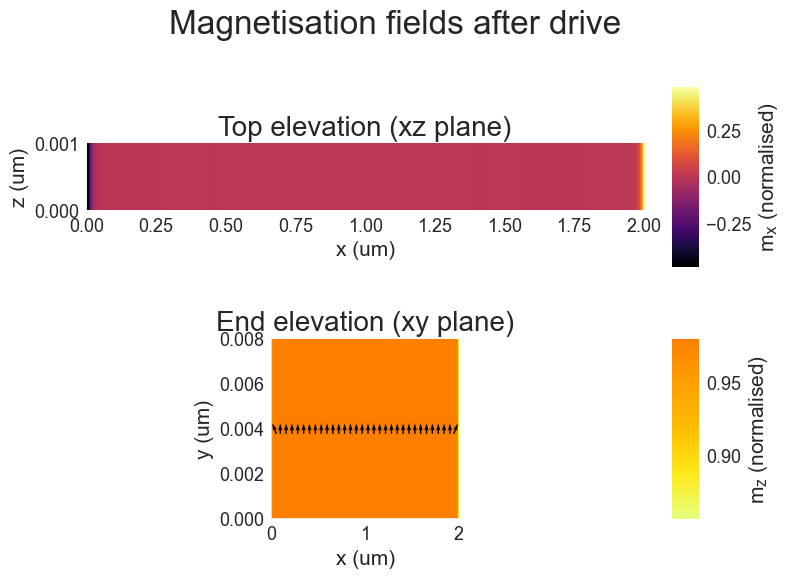

In [72]:
fig2, fig2_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig2.suptitle('Magnetisation fields after drive', fontsize=24)

system.m.orientation.sel('y').resample((256, 2)).x.mpl.scalar(ax=fig2_axs[0], cmap='inferno', colorbar_label='m$_\\text{x}$ (normalised)')
system.m.orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig2_axs[0],
                                               #color_field=system.m.orientation.y.sel("y"),
                                               color='black', alpha=0,
                                               use_color=False,
                                               colorbar=False)
fig2_axs[0].set(title='Top elevation (xz plane)', aspect=240)

system.m.orientation.sel('z').resample((256, 2)).z.mpl.scalar(ax=fig2_axs[1], cmap='Wistia', colorbar_label='m$_\\text{z}$ (normalised)')
system.m.orientation.sel('z').resample((32, 1)).mpl.vector(ax=fig2_axs[1],
                                               color='black',
                                               use_color=False)

fig2_axs[1].set(title='End elevation (xy plane)', aspect=240)


fig2.tight_layout()

In [73]:
m_all_data = md.Drive(name=system.name, number=system.drive_number - 1)
data_m0 = m_all_data.m0.to_xarray().values
np.shape(data_m0)

(1000, 4, 1, 3)

In [74]:
data_mx0 = data_m0[:, 2, 0, 0] / sat_mag
data_my0 = data_m0[:, 2, 0, 1] / sat_mag
data_mz0 = data_m0[:, 2, 0, 2] / sat_mag

In [75]:
data_mx = np.zeros((m_all_data.n, 1000))
data_my = np.zeros((m_all_data.n, 1000))
data_mz = np.zeros((m_all_data.n, 1000))

In [76]:
m_data = m_all_data.to_xarray()

In [77]:
for i, _ in enumerate(m_data):
    data_mx[i] = m_data[i, :, 2, 0, 0].values / sat_mag - data_mx0
    data_my[i] = m_data[i, :, 2, 0, 1].values / sat_mag - data_my0
    data_mz[i] = m_data[i, :, 2, 0, 2].values / sat_mag - data_mz0

In [78]:
def Omega_Moon(H0, Ms, A, D, k, d, gamma, p=1):
    J = 2 * A / (mm.consts.mu0 * Ms)
    DM = 2 * D / (mm.consts.mu0 * Ms)
    
    om = np.sqrt((H0 + 0.25 * Ms + J * (k ** 2)) * (H0 + 3 * Ms * 0.25 + J * (k **2))
                 - (1 + 2 * np.exp(2 * abs(k) * d)) * np.exp(-4 * abs(k) * d) * (Ms ** 2) / 16 
                 ) 
    om += p * DM * k
    
    # the mu0 factor shown in the paper is not necessary if we use gamma
    # in Hz / (A / m)
    om = (gamma) * om
    
    return om

(10.0, 40.0)

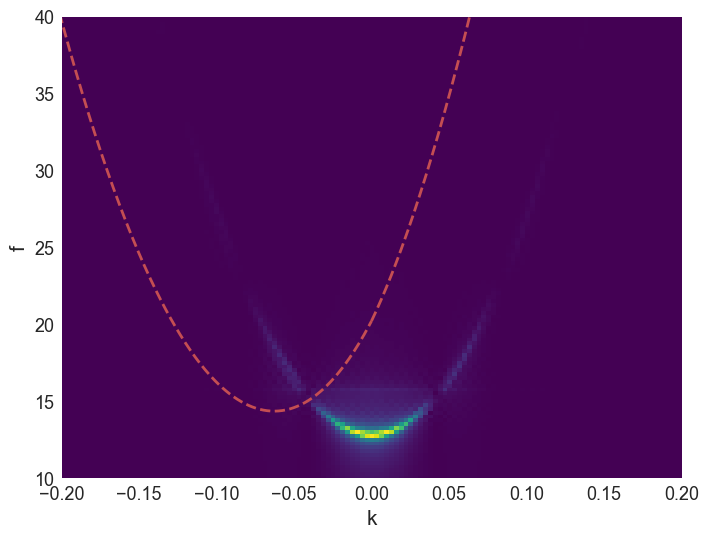

In [108]:
kmax = 0.4 * 1e9
ks = np.linspace(1e-10, kmax, 500)
ks_n = np.linspace(-kmax, 1e-10, 500)
oms = Omega_Moon(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 * mm.consts.mu0 / (2 * np.pi * 1e9), p=1)
oms_n = Omega_Moon(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 * mm.consts.mu0 / (2 * np.pi * 1e9), p=1) 

# Take an FFT of the data
fft_data = np.fft.fft2(data_mx)
fft_data = abs(np.fft.fftshift(fft_data))
times = m_data['t'].values
x = m_data['x'].values
freqs = np.fft.fftfreq(n=len(times), d=(times[1] - times[0]))
freqs = np.fft.fftshift(freqs)
k = np.fft.fftfreq(n=len(x), d=(x[1] - x[0])) / 1e9
k = np.fft.fftshift(k) * 2 * np.pi
# fft_data = np.log10(fft_data ** 2)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(np.real(fft_data), extent=[k[0], k[-1], freqs[0]/1e9, freqs[-1]/1e9], aspect='auto')
ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='C3', label='Theory')
ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', color='C3')


ax.set(facecolor='none', xlabel='k', ylabel='f')

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(10, 40)

In [ ]:
# Temp
my_data = None

m_vals = np.empty((my_data.n, 3))

for i in range(0, my_data.n):
    m_vals[i] = my_data[i].to_xarray()[system_prop.numcells[0], 0, 0]

In [ ]:
fig3, fig3_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
fig3.suptitle(f'Magnetisation fields at different positions', fontsize=24)

fig3_cell1 = 100
fig3_axs[0].plot(my_data.table.data['t'].to_numpy(),
         my_data.to_xarray()[:, fig3_cell1, 0, 0,0])
fig3_axs[0].set(title=f'Cell: {fig3_cell1 * system_prop.cell[0]: 2.2e}', ylabel='m$_\\text{x}$ (A m$^{-1}$)')

fig3_cell2 = 500
fig3_axs[1].plot(my_data.table.data['t'].to_numpy(),
         my_data.to_xarray()[:, fig3_cell2, 0, 0,0])
fig3_axs[1].set(title=f'Cell: {fig3_cell2 * system_prop.cell[0]: 2.2e}', 
                xlabel='Time, t (ns)', ylabel='m$_\\text{x}$ (A m$^{-1}$)')
plt.show()

In [ ]:
def plt_mag(t_val):
    fig4, fig4_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    fig4.suptitle('Magnetisation fields after drive', fontsize=24)
    
    my_data[t_val].orientation.sel('y').resample((256, 2)).x.mpl.scalar(ax=fig4_axs[0], cmap='inferno', colorbar_label='m$_\\text{x}$ (normalised)')
    my_data[t_val].orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig4_axs[0],
                                                   #color_field=system.m.orientation.y.sel("y"),
                                                   color='black', alpha=0,
                                                   use_color=False,
                                                   colorbar=False)
    fig4_axs[0].set(title='Top elevation (xz plane)', aspect=180)
    
    my_data[t_val].orientation.sel('z').resample((256, 2)).z.mpl.scalar(ax=fig4_axs[1], cmap='Wistia', colorbar_label='m$_\\text{z}$ (normalised)')
    my_data[t_val].orientation.sel('z').resample((32, 1)).mpl.vector(ax=fig4_axs[1],
                                                   color='black',
                                                   use_color=False)
    
    fig4_axs[1].set(title='End elevation (xy plane)', aspect=180)
    
    
    fig4.tight_layout()

In [ ]:
plt_mag(90)

In [ ]:
my_data.table.data['t'].to_numpy()

In [ ]:
plt.plot()

In [ ]:
#system.m

In [ ]:
system.table.data.plot('t', 'mx', xlabel='time, t (ns)', ylabel='avg. m$_\\text{x}$ (A m$^{-1}$)')

In [ ]:
position = (1024e-9, 0, 0)

In [ ]:
system.m.orientation((position[0], position[1], position[2]))

In [ ]:
import os

In [ ]:
# Define the directory containing your .omf files
omf_dir = '/Users/cameronmceleney/PycharmProjects/Ubermag/include/breaking_test/drive-14'

# List all .omf files in the directory
omf_files = sorted([f for f in os.listdir(omf_dir) if f.endswith('.omf') and f != 'm0.omf'])

In [ ]:
times = system.table.data['t']

In [111]:
my_data = md.Drive(name='dmi_sp', number=3)

In [114]:
my_data.table.data

,max_mxHxm,E,delta_E,bracket_count,line_min_count,conjugate_cycle_count,cycle_count,cycle_sub_count,energy_calc_count,E_zeeman_static,...,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,DMI_Cnv_z:dmi:Energy,iteration,stage_iteration,stage,mx,my,mz
0,0.095325,-1.430985e-16,0.0,451.0,408.0,12.0,431.0,411.0,860.0,-1.343589e-16,...,10.662686,19.118244,19.118244,-1.129550e-17,848.0,848.0,0.0,2.789839e-10,0.976445,-6.598096e-16


In [ ]:
# Initialize lists to store magnetization components
times = []
mx_values = []
my_values = []
mz_values = []

# Read each .omf file and extract the magnetization at the specified position
for omf_file in omf_files:
    # Read the field from the .omf file
    field = df.Field.from_file(os.path.join(omf_dir, omf_file))
    exit(0)
    
    # Extract the magnetization components at the specified position
    m_at_pos = field(position)
    mx_values.append(m_at_pos[0])
    my_values.append(m_at_pos[1])
    mz_values.append(m_at_pos[2])
    
    # Extract the time from the filename (assuming filenames have time information)
    # Example: "filename_t=0.omf" -> time = 0
    time = float(omf_file.split('t=')[1].split('.omf')[0])
    times.append(time)

In [ ]:
plt.plot(times, mx_values)

In [ ]:
# Plot the magnetization components over time
plt.figure(figsize=(8, 6))
plt.plot(times, mx_values, label='m$_\\text{x}$ (normalized)')
plt.plot(times, my_values, label='m$_\\text{y}$ (normalized)')
#plt.plot(times, mz_values, label='m$_\\text{z}$ (normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization (normalized)')
plt.title('Magnetization components at position {} over time'.format(position))
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig2, (fig2_ax1, fig2_ax2, fig2_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
fig2.suptitle('Magnetisation fields after relaxation (y-plane)', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system.m.x.sel("y").mpl(ax=fig2_ax1, scalar_kw={"colorbar_label": "m$_\\text{x}$ (A m$^{-1}$)"})
fig2_ax1.set(aspect=200)

system.m.y.sel('y').mpl(ax=fig2_ax2, scalar_kw={"colorbar_label": "m$_\\text{y}$ (A m$^{-1}$)"})
fig2_ax2.set(aspect=200)

system.m.z.sel('y').mpl(ax=fig2_ax3, scalar_kw={"colorbar_label": "m$_\\text{z}$ (A m$^{-1}$)"})
fig2_ax3.set(aspect=200)

In [ ]:
data = md.Data(system.name)

In [ ]:
data.info

In [ ]:
# Use only the last time drive
time_drive = data[1]
time_drive.info
print(time_drive.calculator_script)

In [ ]:
#list(time_drive)
#time_drive.to_xarray()

In [ ]:
fig3, fig3_axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
time_drive[700].sel('y').mpl(ax=fig3_axs, vector_kw={'color':'white', 'alpha':0})
fig3_axs.set(aspect=60)

In [ ]:
data_oi = []

In [ ]:

time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)